In [17]:
import torch
import torch.optim as optim
import numpy as np
from NGCF import NGCF
from utility.helper import *
# from utility.batch_test import *
from utility.load_data import *
import multiprocessing
import heapq
import utility.metrics as metrics

import warnings
warnings.filterwarnings('ignore')
from time import time
import easydict

import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
args = easydict.EasyDict({
    'dataset': 'evdriver',
    'regs' : '[1e-5]',
    'embed_size': 64,
    'layer_size': '[64,64,64]',
    'lr': 0.0001,
    'save_flag': 1,
    'pretrain': 0,
    'batch_size': 1024,
    'epoch': 100,
    'verbose': 1,
    'node_dropout': [0.1],
    'mess_dropout': [0.1,0.1,0.1],
    'gpu_id': 0,
    'weights_path': './models',
    'Ks': '[20, 40, 60, 80, 100]',
    'test_flag':'part'})

Ks = eval(args.Ks)
cores = multiprocessing.cpu_count() // 2

In [3]:
def ranklist_by_heapq(user_pos_test, test_items, rating, Ks):
    item_score = {}
    for i in test_items:
        item_score[i] = rating[i]

    K_max = max(Ks)
    K_max_item_score = heapq.nlargest(K_max, item_score, key=item_score.get)

    r = []
    for i in K_max_item_score:
        if i in user_pos_test:
            r.append(1)
        else:
            r.append(0)
    auc = 0.
    return r, auc

def get_auc(item_score, user_pos_test):
    item_score = sorted(item_score.items(), key=lambda kv: kv[1])
    item_score.reverse()
    item_sort = [x[0] for x in item_score]
    posterior = [x[1] for x in item_score]

    r = []
    for i in item_sort:
        if i in user_pos_test:
            r.append(1)
        else:
            r.append(0)
    auc = metrics.auc(ground_truth=r, prediction=posterior)
    return auc

def ranklist_by_sorted(user_pos_test, test_items, rating, Ks):
    item_score = {}
    for i in test_items:
        item_score[i] = rating[i]

    K_max = max(Ks)
    K_max_item_score = heapq.nlargest(K_max, item_score, key=item_score.get)

    r = []
    for i in K_max_item_score:
        if i in user_pos_test:
            r.append(1)
        else:
            r.append(0)
    auc = get_auc(item_score, user_pos_test)
    return r, auc

def get_performance(user_pos_test, r, auc, Ks):
    precision, recall, ndcg, hit_ratio = [], [], [], []

    for K in Ks:
        precision.append(metrics.precision_at_k(r, K))
        recall.append(metrics.recall_at_k(r, K, len(user_pos_test)))
        ndcg.append(metrics.ndcg_at_k(r, K, user_pos_test))
        hit_ratio.append(metrics.hit_at_k(r, K))

    return {'recall': np.array(recall), 'precision': np.array(precision),
            'ndcg': np.array(ndcg), 'hit_ratio': np.array(hit_ratio), 'auc': auc}

def test_one_user(x):
    # user u's ratings for user u
    rating = x[0]
    #uid
    u = x[1]
    #user u's items in the training set
    try:
        training_items = data_generator.train_items[u]
    except Exception:
        training_items = []
    #user u's items in the test set
    user_pos_test = data_generator.test_set[u]

    all_items = set(range(ITEM_NUM))

    test_items = list(all_items - set(training_items))

    if args.test_flag == 'part':
        r, auc = ranklist_by_heapq(user_pos_test, test_items, rating, Ks)
    else:
        r, auc = ranklist_by_sorted(user_pos_test, test_items, rating, Ks)

    return get_performance(user_pos_test, r, auc, Ks)

def test(model, users_to_test, drop_flag=False, batch_test_flag=False):
    result = {'precision': np.zeros(len(Ks)), 'recall': np.zeros(len(Ks)), 'ndcg': np.zeros(len(Ks)),
              'hit_ratio': np.zeros(len(Ks)), 'auc': 0.}

    pool = multiprocessing.Pool(cores)

    u_batch_size = BATCH_SIZE * 2
    i_batch_size = BATCH_SIZE

    test_users = users_to_test
    n_test_users = len(test_users)
    n_user_batchs = n_test_users // u_batch_size + 1

    count = 0

    for u_batch_id in range(n_user_batchs):
        start = u_batch_id * u_batch_size
        end = (u_batch_id + 1) * u_batch_size

        user_batch = test_users[start: end]

        if batch_test_flag:
            # batch-item test
            n_item_batchs = ITEM_NUM // i_batch_size + 1
            rate_batch = np.zeros(shape=(len(user_batch), ITEM_NUM))

            i_count = 0
            for i_batch_id in range(n_item_batchs):
                i_start = i_batch_id * i_batch_size
                i_end = min((i_batch_id + 1) * i_batch_size, ITEM_NUM)

                item_batch = range(i_start, i_end)

                if drop_flag == False:
                    u_g_embeddings, pos_i_g_embeddings, _ = model(user_batch,
                                                                  item_batch,
                                                                  [],
                                                                  drop_flag=False)
                    i_rate_batch = model.rating(u_g_embeddings, pos_i_g_embeddings).detach().cpu()
                else:
                    u_g_embeddings, pos_i_g_embeddings, _ = model(user_batch,
                                                                  item_batch,
                                                                  [],
                                                                  drop_flag=True)
                    i_rate_batch = model.rating(u_g_embeddings, pos_i_g_embeddings).detach().cpu()

                rate_batch[:, i_start: i_end] = i_rate_batch
                i_count += i_rate_batch.shape[1]

            assert i_count == ITEM_NUM

        else:
            # all-item test
            item_batch = range(ITEM_NUM)

            if drop_flag == False:
                u_g_embeddings, pos_i_g_embeddings, _ = model(user_batch,
                                                              item_batch,
                                                              [],
                                                              drop_flag=False)
                rate_batch = model.rating(u_g_embeddings, pos_i_g_embeddings).detach().cpu()
            else:
                u_g_embeddings, pos_i_g_embeddings, _ = model(user_batch,
                                                              item_batch,
                                                              [],
                                                              drop_flag=True)
                rate_batch = model.rating(u_g_embeddings, pos_i_g_embeddings).detach().cpu()

        user_batch_rating_uid = zip(rate_batch.numpy(), user_batch)
        batch_result = pool.map(test_one_user, user_batch_rating_uid)
        count += len(batch_result)

        for re in batch_result:
            result['precision'] += re['precision']/n_test_users
            result['recall'] += re['recall']/n_test_users
            result['ndcg'] += re['ndcg']/n_test_users
            result['hit_ratio'] += re['hit_ratio']/n_test_users
            result['auc'] += re['auc']/n_test_users


    assert count == n_test_users
    pool.close()
    return result


In [5]:
data_generator = Data(path='../Data/evdriver', batch_size=1024)
USR_NUM, ITEM_NUM = data_generator.n_users, data_generator.n_items
N_TRAIN, N_TEST = data_generator.n_train, data_generator.n_test
BATCH_SIZE = args.batch_size

n_users=185336, n_items=30895
n_interactions=852546
n_train=667210, n_test=185336, sparsity=0.00015


In [6]:
plain_adj, norm_adj, mean_adj = data_generator.get_adj_mat()

already load adj matrix (216231, 216231) 0.39972734451293945


In [7]:
users_to_test = list(data_generator.test_set.keys())

In [8]:
users_to_test[-1]

185335

In [9]:
import pickle
torch.manual_seed(34)
np.random.seed(34)

drop_flag = False
batch_test_flag=False

args.device = torch.device('cuda:' + str(args.gpu_id))
model = NGCF(data_generator.n_users,
                 data_generator.n_items,
                 norm_adj, args).to(args.device)
with open('./dgcf.pkl', 'rb') as f:
    model.load_state_dict(torch.load(f))

In [10]:
result = {'precision': np.zeros(len(Ks)), 'recall': np.zeros(len(Ks)), 'ndcg': np.zeros(len(Ks)),
            'hit_ratio': np.zeros(len(Ks)), 'auc': 0.}

pool = multiprocessing.Pool(cores)

u_batch_size = BATCH_SIZE * 2
i_batch_size = BATCH_SIZE

test_users = users_to_test
n_test_users = len(test_users)
n_user_batchs = n_test_users // u_batch_size + 1
print(n_user_batchs)
count = 0

entire_rank = torch.tensor([])

91


Process ForkPoolWorker-3:
Process ForkPoolWorker-10:
Process ForkPoolWorker-6:
Process ForkPoolWorker-9:
Process ForkPoolWorker-2:
Process ForkPoolWorker-5:
Process ForkPoolWorker-4:
Process ForkPoolWorker-8:
Process ForkPoolWorker-1:
Process ForkPoolWorker-7:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/lib/python3.8/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/lib/python3.8/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/usr/lib/python3.8/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/usr/lib/python3.8/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/usr/lib/python3.8/multiprocessing/p

In [ ]:
for u_batch_id in tqdm(range(n_user_batchs)):
    start = u_batch_id * u_batch_size
    end = (u_batch_id + 1) * u_batch_size

    user_batch = test_users[start: end]

    if batch_test_flag:
        # batch-item test
        n_item_batchs = ITEM_NUM // i_batch_size + 1
        rate_batch = np.zeros(shape=(len(user_batch), ITEM_NUM))

        i_count = 0
        for i_batch_id in tqdm(range(n_item_batchs)):
            i_start = i_batch_id * i_batch_size
            i_end = min((i_batch_id + 1) * i_batch_size, ITEM_NUM)

            item_batch = range(i_start, i_end)

            if drop_flag == False:
                u_g_embeddings, pos_i_g_embeddings, _ = model(user_batch,
                                                                item_batch,
                                                                [],
                                                                drop_flag=False)
                i_rate_batch = model.rating(u_g_embeddings, pos_i_g_embeddings).detach().cpu()
            else:
                u_g_embeddings, pos_i_g_embeddings, _ = model(user_batch,
                                                                item_batch,
                                                                [],
                                                                drop_flag=True)
                i_rate_batch = model.rating(u_g_embeddings, pos_i_g_embeddings).detach().cpu()

            rate_batch[:, i_start: i_end] = i_rate_batch
            i_count += i_rate_batch.shape[1]

        assert i_count == ITEM_NUM

    else:
        # all-item test
        item_batch = range(ITEM_NUM)

        if drop_flag == False:
            u_g_embeddings, pos_i_g_embeddings, _ = model(user_batch,
                                                            item_batch,
                                                            [],
                                                            drop_flag=False)
            rate_batch = model.rating(u_g_embeddings, pos_i_g_embeddings).detach().cpu()
        else:
            u_g_embeddings, pos_i_g_embeddings, _ = model(user_batch,
                                                            item_batch,
                                                            [],
                                                            drop_flag=True)
            rate_batch = model.rating(u_g_embeddings, pos_i_g_embeddings).detach().cpu()

    
    entire_rank = torch.cat((entire_rank, rate_batch), dim=0)
    user_batch_rating_uid = zip(rate_batch.numpy(), user_batch)
    batch_result = pool.map(test_one_user, user_batch_rating_uid)
    count += len(batch_result)

    for re in batch_result:
        result['precision'] += re['precision']/n_test_users
        result['recall'] += re['recall']/n_test_users
        result['ndcg'] += re['ndcg']/n_test_users
        result['hit_ratio'] += re['hit_ratio']/n_test_users
        result['auc'] += re['auc']/n_test_users


assert count == n_test_users
pool.close()

 29%|██▊       | 26/91 [01:33<04:12,  3.89s/it]

In [12]:
import torch
import os

# 저장할 디렉토리 설정
save_dir = './rank_batches'
os.makedirs(save_dir, exist_ok=True)

# 배치 처리 루프
for u_batch_id in tqdm(range(n_user_batchs)):
    start = u_batch_id * u_batch_size
    end = (u_batch_id + 1) * u_batch_size

    user_batch = test_users[start: end]

    if batch_test_flag:
        # 배치-아이템 테스트
        n_item_batchs = ITEM_NUM // i_batch_size + 1
        rate_batch = np.zeros(shape=(len(user_batch), ITEM_NUM))

        i_count = 0
        for i_batch_id in range(n_item_batchs):
            i_start = i_batch_id * i_batch_size
            i_end = min((i_batch_id + 1) * i_batch_size, ITEM_NUM)

            item_batch = range(i_start, i_end)

            if not drop_flag:
                u_g_embeddings, pos_i_g_embeddings, _ = model(user_batch, item_batch, [], drop_flag=False)
                i_rate_batch = model.rating(u_g_embeddings, pos_i_g_embeddings).detach().cpu()
            else:
                u_g_embeddings, pos_i_g_embeddings, _ = model(user_batch, item_batch, [], drop_flag=True)
                i_rate_batch = model.rating(u_g_embeddings, pos_i_g_embeddings).detach().cpu()

            rate_batch[:, i_start: i_end] = i_rate_batch
            i_count += i_rate_batch.shape[1]

        assert i_count == ITEM_NUM

    else:
        # 모든 아이템 테스트
        item_batch = range(ITEM_NUM)

        if not drop_flag:
            u_g_embeddings, pos_i_g_embeddings, _ = model(user_batch, item_batch, [], drop_flag=False)
            rate_batch = model.rating(u_g_embeddings, pos_i_g_embeddings).detach().cpu()
        else:
            u_g_embeddings, pos_i_g_embeddings, _ = model(user_batch, item_batch, [], drop_flag=True)
            rate_batch = model.rating(u_g_embeddings, pos_i_g_embeddings).detach().cpu()

    # 배치 결과 저장
    batch_file = os.path.join(save_dir, f'batch_{u_batch_id}.pt')
    torch.save(rate_batch, batch_file)

    user_batch_rating_uid = zip(rate_batch.numpy(), user_batch)
    batch_result = pool.map(test_one_user, user_batch_rating_uid)
    count += len(batch_result)

    for re in batch_result:
        result['precision'] += re['precision'] / n_test_users
        result['recall'] += re['recall'] / n_test_users
        result['ndcg'] += re['ndcg'] / n_test_users
        result['hit_ratio'] += re['hit_ratio'] / n_test_users
        result['auc'] += re['auc'] / n_test_users

assert count == n_test_users
pool.close()


100%|██████████| 91/91 [06:00<00:00,  3.96s/it]


AssertionError: 

In [13]:
count

199672

In [14]:
n_test_users

185336

In [23]:
batch_file = os.path.join(save_dir, f'batch_0.pt')
rate_batch = torch.load(batch_file)
rate_batch

tensor([[-0.3784,  0.3453,  0.2978,  ...,  0.6219, -0.0649,  0.4069],
        [-0.5842,  0.8983, -2.1777,  ..., -1.5230, -0.8950, -1.1614],
        [-0.0282, -0.2790, -1.0631,  ...,  0.5330,  0.0900, -1.1493],
        ...,
        [-0.2404, -1.2683, -1.8942,  ..., -0.7535, -0.7272, -2.0102],
        [ 0.9465, -1.4659, -0.5820,  ..., -0.3537, -0.7689, -1.7913],
        [ 0.1829,  0.3101, -1.2820,  ...,  0.2224,  0.0694,  0.0291]])

In [24]:
len(rate_batch)

2048

In [33]:
import torch
import numpy as np
import os

# 저장할 디렉토리 설정
save_dir = './rank_batches2'
os.makedirs(save_dir, exist_ok=True)

# 배치 처리 루프
for u_batch_id in tqdm(range(n_user_batchs)):
    start = u_batch_id * u_batch_size
    end = (u_batch_id + 1) * u_batch_size

    user_batch = test_users[start: end]

    if batch_test_flag:
        # 배치-아이템 테스트
        n_item_batchs = ITEM_NUM // i_batch_size + 1
        rate_batch = np.zeros(shape=(len(user_batch), ITEM_NUM))

        i_count = 0
        for i_batch_id in range(n_item_batchs):
            i_start = i_batch_id * i_batch_size
            i_end = min((i_batch_id + 1) * i_batch_size, ITEM_NUM)

            item_batch = range(i_start, i_end)

            if not drop_flag:
                u_g_embeddings, pos_i_g_embeddings, _ = model(user_batch, item_batch, [], drop_flag=False)
                i_rate_batch = model.rating(u_g_embeddings, pos_i_g_embeddings).detach().cpu().numpy()
            else:
                u_g_embeddings, pos_i_g_embeddings, _ = model(user_batch, item_batch, [], drop_flag=True)
                i_rate_batch = model.rating(u_g_embeddings, pos_i_g_embeddings).detach().cpu().numpy()

            rate_batch[:, i_start: i_end] = i_rate_batch
            i_count += i_rate_batch.shape[1]

        assert i_count == ITEM_NUM

    else:
        # 모든 아이템 테스트
        item_batch = range(ITEM_NUM)

        if not drop_flag:
            u_g_embeddings, pos_i_g_embeddings, _ = model(user_batch, item_batch, [], drop_flag=False)
            rate_batch = model.rating(u_g_embeddings, pos_i_g_embeddings).detach().cpu().numpy()
        else:
            u_g_embeddings, pos_i_g_embeddings, _ = model(user_batch, item_batch, [], drop_flag=True)
            rate_batch = model.rating(u_g_embeddings, pos_i_g_embeddings).detach().cpu().numpy()

    # 배치 결과 저장
    batch_file = os.path.join(save_dir, f'batch_{u_batch_id}.npy')
    np.save(batch_file, rate_batch)

    user_batch_rating_uid = zip(rate_batch, user_batch)
    batch_result = pool.map(test_one_user, user_batch_rating_uid)
    count += len(batch_result)

    for re in batch_result:
        result['precision'] += re['precision'] / n_test_users
        result['recall'] += re['recall'] / n_test_users
        result['ndcg'] += re['ndcg'] / n_test_users
        result['hit_ratio'] += re['hit_ratio'] / n_test_users
        result['auc'] += re['auc'] / n_test_users

assert count == n_test_users
pool.close()

100%|██████████| 91/91 [06:30<00:00,  4.29s/it]


AssertionError: 

In [21]:
import pickle, pickle5
import pandas as pd

with open('../Data/evdriver/preprocessed/meta.pickle', 'rb') as f:
    meta = pickle.load(f)

with open('../Data/evdriver/preprocessed/drivers.pickle', 'rb') as f:
    train_dv = pickle.load(f)

with open('../Data/evdriver/preprocessed/testset_df.pickle', 'rb') as f:
    test_dv = pickle.load(f)

test_dv = test_dv.sort_values(by=['Driver']).reset_index(drop=True)


In [22]:
def evaluation(result, driver_id, test_dv, meta, criteria):
    location = test_dv.loc[test_dv['Driver'] == driver_id][criteria].values[0]
    teststat = test_dv.loc[test_dv['Driver'] == driver_id]['statid'].values[0]
    speed = test_dv.loc[test_dv['Driver'] == driver_id]['speed'].values
    if len(speed) == 1:
        flag = True
    else:
        flag = False

    driver_pref = result[driver_id]
    #[1011, 14000, 13000] -> statid의 list
    driver_rank = driver_pref.argsort()[::-1].astype(str)
    #하나의 Cluster로 위치 필터링
    driver_meta = meta[meta[criteria] == location]
    recommended_df = pd.DataFrame([])

    for i in range(len(driver_rank)):
        if len(recommended_df) > 19:
            false_count = len(recommended_df) - recommended_df.duplicated('statid').sum()
            if false_count == 20:
                break
        #추천된 statid가 Cluster에 속하면,
        if driver_rank[i] in driver_meta['statid'].values:
            stat_driver = driver_meta.loc[driver_meta['statid'] == driver_rank[i]]
            #추천된 statid의 speed가 testset의 speed와 같으면,
            if flag:
                if stat_driver['speed'].values[0] == speed:
                    recommended_df = pd.concat([recommended_df, stat_driver])
            else:
                recommended_df = pd.concat([recommended_df, stat_driver])
                
    if flag:
        recommended_df = recommended_df.loc[recommended_df['speed'] == speed[0]].reset_index(drop=True)
    else:
        recommended_df = recommended_df.drop_duplicates('statid').reset_index(drop=True)

    try:
        rank = recommended_df.loc[recommended_df['statid'] == teststat].index[0] 
        rank = rank + 1
    except:
        rank = 0
    return recommended_df, rank, len(recommended_df)

def get_coordinates(driver_id, meta, test_dv, candidate):
    gt_zscode = test_dv.loc[test_dv['Driver'] == driver_id]['zscode'].values[0]
    gt_cluster = test_dv.loc[test_dv['Driver'] == driver_id]['Cluster'].values[0]
    gt_speeds = test_dv.loc[test_dv['Driver'] == driver_id]['speed']
    if len(gt_speeds.values) == 1:
        gt_speed = gt_speeds.values[0]
    else:
        gt_speed = gt_speeds.value_counts().keys()[0]
    
    meta_zscode = meta[meta['zscode'] == gt_zscode]
    meta_zscode = meta_zscode.loc[meta_zscode['speed'] == gt_speed]
    meta_cluster = meta.loc[meta['Cluster'] == gt_cluster]
    meta_cluster = meta_cluster.loc[meta_cluster['speed'] == gt_speed]

    zscode_cor = meta_zscode[['lat','lng']].values
    cluster_cor = meta_cluster[['lat','lng']].values
    candidate_cor = candidate[['lat','lng']].values
    ground_truth_cor = test_dv.loc[test_dv['Driver'] == driver_id][['lat','lng']].values
    

    return zscode_cor, cluster_cor, candidate_cor, ground_truth_cor

def show_plot(zscode_cor, cluster_cor, candidate_cor, gt_cor, driver_id):
    plt.scatter(zscode_cor[:, 1], zscode_cor[:, 0], marker='o', color='blue', label='zscode', s=5)
    plt.scatter(cluster_cor[:, 1], cluster_cor[:, 0], marker='o', color='red', label='cluster', s=5)
    plt.scatter(candidate_cor[:, 1], candidate_cor[:, 0], marker='o', color='green', label='candidate', s=5)
    plt.scatter(gt_cor[:, 1], gt_cor[:, 0], marker='x', color='black', label='Ground Truth', s=30)
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.title(f'Scatter Plot of Coordinates for driver: {driver_id}')
    plt.legend()
    plt.show()

def visulization(result, driver_id, test_dv, meta, criteria):
    recommended_df, rank, length = evaluation(result, driver_id, test_dv, meta, criteria)
    zscode_cor, cluster_cor, candidate_cor, gt_cor = get_coordinates(driver_id, meta, test_dv, recommended_df)
    show_plot(zscode_cor, cluster_cor, candidate_cor, gt_cor, driver_id)
    return 

In [34]:
batch_file = os.path.join(save_dir, f'batch_0.npy')
rate_batch = np.load(batch_file)
rate_batch

array([[-0.70081496,  0.18153189,  0.31187984, ...,  0.4729136 ,
        -0.05474171,  0.7154179 ],
       [-0.5952144 ,  0.9281276 , -2.0627391 , ..., -1.5854123 ,
        -0.8868639 , -1.2506481 ],
       [ 0.17927273,  0.08900154, -1.1095641 , ...,  0.46728536,
         0.02079   , -1.0934571 ],
       ...,
       [-0.15912785, -1.3024961 , -1.721754  , ..., -0.7657489 ,
        -0.74881816, -1.9240354 ],
       [ 0.959815  , -1.4766943 , -0.42791018, ..., -0.52133274,
        -0.7622153 , -1.4521686 ],
       [-0.01630066,  0.30078766, -1.0833848 , ..., -0.16655296,
         0.17395033,  0.25767943]], dtype=float32)

In [36]:
rate_batch[0]

array([-0.70081496,  0.18153189,  0.31187984, ...,  0.4729136 ,
       -0.05474171,  0.7154179 ], dtype=float32)

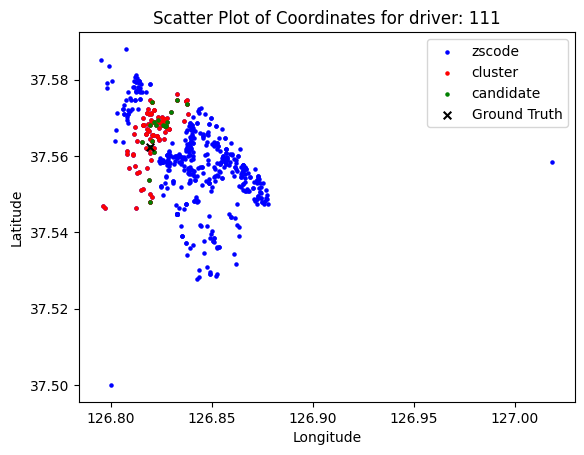

In [22]:
visulization(rate_batch, 111, test_dv, meta, 'Cluster')

In [42]:
test_dv['zscode']

0         41500
1         11260
2         11500
3         41110
4         11710
          ...  
201275    28237
201276    28237
201277    41590
201278    11410
201279    11410
Name: zscode, Length: 201280, dtype: object

In [31]:
k = [1,2,3,4,5,6]
k1 = np.array(k)
k1.argsort()[::-1].astype(str)

array(['5', '4', '3', '2', '1', '0'], dtype='<U21')

In [ ]:
# 저장된 배치 배열을 결합하는 함수
def load_and_concatenate_batches(save_dir, n_batches):
    batches = []
    for u_batch_id in range(n_batches):
        batch_file = os.path.join(save_dir, f'batch_{u_batch_id}.npy')
        rate_batch = np.load(batch_file)
        batches.append(rate_batch)
    entire_rank = np.concatenate(batches, axis=0)
    return entire_rank

# 전체 배치 개수 계산
n_batches = n_user_batchs

# 저장된 배치 배열을 읽어서 결합
entire_rank = load_and_concatenate_batches(save_dir, n_batches)

In [26]:
len(test_dv)

201280

In [31]:
busiid = test_dv.loc[test_dv['Driver'] == 0]['busiid']

In [32]:
busiid

0    63
Name: busiid, dtype: int64

In [35]:
rate_batch[0].argmax()

16295

In [44]:
k = [5,5,5,5,5]
t = np.array(k)//5
t

array([1, 1, 1, 1, 1])

In [45]:
recalls = np.zeros(5)

In [47]:
recalls + t

array([1., 1., 1., 1., 1.])

In [51]:
import numpy as np

# 예제 배열
arr = np.array([3, 1, 2, 4, 5])

# 배열을 내림차순으로 정렬했을 때의 인덱스
sorted_indices_desc = np.argsort(arr)[::-1]
print(sorted_indices_desc + 1)
# 원래 배열을 내림차순으로 정렬된 상태로 만들기
sorted_arr_desc = arr[sorted_indices_desc]

print("원래 배열:", arr)
print("내림차순 정렬된 인덱스:", sorted_indices_desc)
print("내림차순 정렬된 배열:", sorted_arr_desc)


[5 4 1 3 2]
원래 배열: [3 1 2 4 5]
내림차순 정렬된 인덱스: [4 3 0 2 1]
내림차순 정렬된 배열: [5 4 3 2 1]


In [75]:
sorted_indices_desc = np.argsort(rate_batch[44])[::-1] + 1
indices = np.where(sorted_indices_desc == 12085)
indices

(array([5310]),)

In [69]:
len(sorted_indices_desc)

30895